In [1]:
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn,optim
import matplotlib.pyplot as plt
torch.manual_seed(2017) #为CPU设置种子用于生成随机数，以使得结果是确定的

In [2]:
# 读入数据 x 和 y
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168],
                    [9.779], [6.182], [7.59], [2.167], [7.042],
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573],
                    [3.366], [2.596], [2.53], [1.221], [2.827],
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

In [3]:
# 转换成 Tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

# 定义参数 w 和 b
w = Variable(torch.randn(1), requires_grad=True) # 随机初始化
b = Variable(torch.zeros(1), requires_grad=True) # 使用 0 进行初始化

In [4]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression,self).__init__()
        self.linear = nn.Linear(1,1)  #输入输出是一维
        
        
    def forward(self,x):
        out = self.linear(x)
        return out

In [5]:
if torch.cuda.is_available():
    model = LinearRegression().cuda()  #放到GPU上
else:
    model = LinearRegression()
    

In [13]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 100
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = Variable(x_train).cuda()
        target = Variable(y_train).cuda()
    else:
        inputs = Variable(x_train)
        target = Variable(y_train)
    out = model(inputs)
    loss = criterion(out,target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}],loss:{:.6f}'.format(epoch+1, num_epochs, loss.data))

Epoch[20/100],loss:0.174412
Epoch[40/100],loss:0.174355
Epoch[60/100],loss:0.174300
Epoch[80/100],loss:0.174245
Epoch[100/100],loss:0.174190


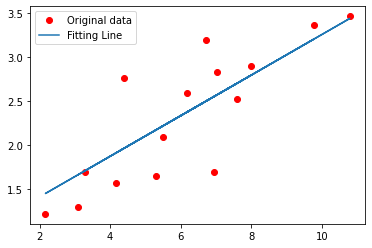

In [12]:
model.eval()
predict = model(Variable(x_train).cuda())

predict = predict.data.cpu().numpy()
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train.numpy(), predict, label='Fitting Line')
# 显示图例
plt.legend() 
plt.show()
 
# 保存模型
torch.save(model.state_dict(), './linear.pth')


In [113]:


def make_features(x):
    """建立特征矩阵，由每一列组成 [x, x^2, x^3]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in range(1, 4)], 1)
    
w_target = torch.FloatTensor([0.5,3,2.4]).unsqueeze(1)
b_target = torch.FloatTensor([0.9])

def f(x):
    return x.mm(w_target)+b_target[0]

def get_batch(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    if torch.cuda.is_available():
        return Variable(x).cuda(), Variable(y).cuda()
    else:
        return Variable(x),Variable(y)
    
def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    result += '{:.2f}'.format(b)
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    
    return result


    
class poly_model(nn.Module):
    def __init__(self):
        super(poly_model,self).__init__()
        self.poly = nn.Linear(3,1)
    
    def forward(self,x):
        out = self.poly(x)
        return out
    
if torch.cuda.is_available():
    model = poly_model().cuda()
else:
    model = poly_model()
    
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3)


epoch = 0
while True:
    
    # Get data
    batch_x, batch_y = get_batch()

    # Forward pass
    output = model(batch_x)
    loss = criterion(output,batch_y)
    print_loss = loss.data
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Apply gradients
    optimizer.step()
    
    
    if (epoch+1) % 20 == 0:
        print('Loss: {:.6f} after {} batches'.format(loss, epoch+1))
#         print(list(model.parameters())[0][0].cpu().detach().numpy())
#         print(list(model.parameters())[1][0].cpu().detach().numpy())
#         print(w_target[:,0].numpy())
#         print(b_target.numpy())

        print('==> Learned function:\t' + poly_desc(list(model.parameters())[0][0].cpu().detach().numpy(), list(model.parameters())[1][0].cpu().detach().numpy()))
        print('==> Actual function:\t' + poly_desc(w_target[:,0].numpy(), b_target[0].numpy()))

    
    epoch += 1
    
    # Stop criterion
    if loss < 1e-3:
        break
        


Loss: 75.187805 after 20 batches
==> Learned function:	y = 0.21+0.41 x^3 +0.14 x^2 +0.74 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 9.349182 after 40 batches
==> Learned function:	y = 0.36+0.60 x^3 +0.63 x^2 +1.79 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 15.976631 after 60 batches
==> Learned function:	y = 0.46+0.63 x^3 +0.85 x^2 +1.88 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 12.031470 after 80 batches
==> Learned function:	y = 0.56+0.69 x^3 +1.16 x^2 +2.18 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 2.347862 after 100 batches
==> Learned function:	y = 0.64+0.70 x^3 +1.35 x^2 +2.30 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 6.700090 after 120 batches
==> Learned function:	y = 0.72+0.70 x^3 +1.58 x^2 +2.23 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 4.130729 after 140 batches
==> Learned function:	y = 0.78+0.72 x^3 +1.7

Loss: 0.011450 after 1160 batches
==> Learned function:	y = 1.00+0.60 x^3 +2.96 x^2 +2.38 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 0.010556 after 1180 batches
==> Learned function:	y = 1.00+0.60 x^3 +2.96 x^2 +2.38 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 0.006566 after 1200 batches
==> Learned function:	y = 1.00+0.60 x^3 +2.96 x^2 +2.38 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 0.006813 after 1220 batches
==> Learned function:	y = 1.00+0.60 x^3 +2.96 x^2 +2.38 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 0.006434 after 1240 batches
==> Learned function:	y = 0.99+0.60 x^3 +2.96 x^2 +2.38 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 0.006498 after 1260 batches
==> Learned function:	y = 0.99+0.60 x^3 +2.96 x^2 +2.38 x^1 
==> Actual function:	y = 0.90+0.50 x^3 +3.00 x^2 +2.40 x^1 
Loss: 0.008559 after 1280 batches
==> Learned function:	y = 0.99+0.59 

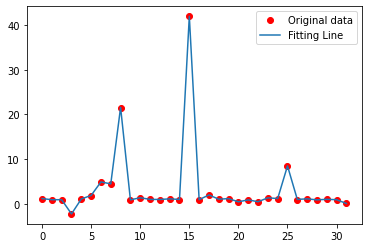

In [114]:
output = output.cpu().data.numpy()#将output转为numpy型
plt.plot(batch_y.cpu().numpy(),'ro',label='Original data')
plt.plot(output,label='Fitting Line')
plt.legend() 
plt.show()


In [109]:
print(output)

[[ 2.2237077 ]
 [ 1.4601905 ]
 [ 3.1759973 ]
 [ 1.0869923 ]
 [ 6.592859  ]
 [ 0.8902745 ]
 [ 1.1644628 ]
 [ 0.9206019 ]
 [ 1.545413  ]
 [ 1.2803873 ]
 [ 1.1254132 ]
 [-3.8108935 ]
 [-6.8131843 ]
 [ 0.89056057]
 [ 7.7269893 ]
 [ 1.2434808 ]
 [24.963268  ]
 [ 0.8964644 ]
 [ 2.1040618 ]
 [ 0.96793944]
 [ 2.5804644 ]
 [ 7.8577423 ]
 [ 1.6582615 ]
 [ 1.2287614 ]
 [ 1.0732735 ]
 [ 1.057225  ]
 [34.351254  ]
 [ 0.2654239 ]
 [ 3.5385942 ]
 [ 1.1618571 ]
 [ 1.4582648 ]
 [ 4.4697266 ]]
